In [1]:
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from unidecode import unidecode
import re

## Adquisicion de los datos iniciales

In [2]:
ping_data = pd.read_excel("base_dataset.xlsx", sheet_name="ping")
time_data = pd.read_excel("base_dataset.xlsx", sheet_name="time")
play_data = pd.read_excel("base_dataset.xlsx", sheet_name="play")

raw_data = pd.concat([ping_data, time_data, play_data])

print(f"Cantidad de ejemplos: {len(raw_data)}")
raw_data.head()

Cantidad de ejemplos: 113


,sentence,command
0,¿Cuánto ping tengo?,ping
1,¿Tengo ping?,ping
2,ping,ping
3,¿Hay ping?,ping
4,contame el ping,ping


## Limpieza de datos

In [3]:
raw_data.dropna()

data = pd.DataFrame()
data["sentence"] = raw_data["sentence"].map(lambda s: unidecode(re.sub(r'[^\w\s]', '', s.lower())))
data["command"] = raw_data["command"]

data.head()

,sentence,command
0,cuanto ping tengo,ping
1,tengo ping,ping
2,ping,ping
3,hay ping,ping
4,contame el ping,ping


In [4]:
command_index = { cmd: i for i, cmd in enumerate(data["command"].unique()) }
inverse_command_index = { i: cmd for cmd, i in command_index.items() }

targets = data["command"].map(lambda cmd: command_index[cmd]).values

## Distribucion de los datos

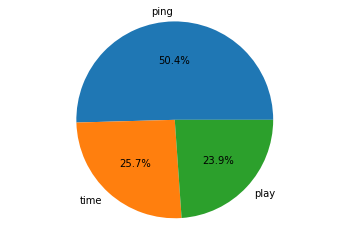

In [5]:
command_distribution = { cmd: 0 for cmd in command_index.keys() }

for cmd_index in targets:
    command_distribution[inverse_command_index[cmd_index]] += 1
    
labels = command_distribution.keys()
sizes = command_distribution.values()

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')

plt.show()

## Seleccion de conjunto de entrenamiento y prueba

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data["sentence"].values, targets, test_size=0.2)

print(f"Datos de entrenamiento: {len(train_data)}")
print(f"Datos de prueba: {len(test_data)}")

Datos de entrenamiento: 90
Datos de prueba: 23


## Preparación

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["sentence"].values)

word_index = tokenizer.word_index
word_index["<PAD>"] = 0

with(open("word_index.pkl", "wb")) as f:
    pickle.dump(word_index, f)

def pad_data(data_array):
    MAX_LEN = 10
    padded_array = pad_sequences(data_array, value=word_index["<PAD>"], maxlen=MAX_LEN, padding="post")
    return tf.convert_to_tensor(padded_array)

def encode_data(data_array):
    return pad_data(tokenizer.texts_to_sequences(data_array))

encoded_train_data = encode_data(train_data)
encoded_test_data = encode_data(test_data)

## Modelado

In [8]:
from tensorflow import keras

vocabulary_size = len(word_index)

model = keras.Sequential()

#model.add(keras.layers.experimental.preprocessing.TextVectorization(max_tokens=5000, output_mode='int', output_sequence_length=10, input_shape=(1,)))
model.add(keras.layers.Embedding(vocabulary_size, 128))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(3, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         8320      
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 8,707
Trainable params: 8,707
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])



print("Training started...")
EPOCHS = 150
history = model.fit(
    encoded_train_data, 
    train_targets,
    epochs=EPOCHS,
    validation_split=0.1, 
    verbose=0
)

print("DONE!")

Training started...
DONE!


In [10]:
model.save("model.h5")

## Evaluacion

Entrenamiento:

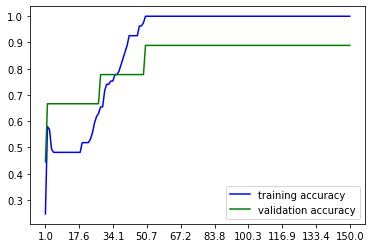

In [11]:
history_dict = history.history

xticks = np.arange(1, EPOCHS+1)
plt.xticks(xticks)
plt.plot(xticks, history_dict['acc'], "b", label="training accuracy")
plt.plot(xticks, history_dict['val_acc'], "g", label="validation accuracy")
plt.xticks(np.linspace(1, EPOCHS, 10))
plt.legend()
plt.show()

In [12]:
results = model.evaluate(encoded_test_data, test_targets)
print(f"Precision: {results[1]}")

1/1 [==============================] - 0s 12ms/step - loss: 0.1054 - acc: 1.0000
Precision: 1.0


In [13]:
predictions = model.predict(encoded_test_data)

Cantidad de errores:

In [14]:
def predicted_classification(test_index):
    best_index = np.argmax(predictions[test_index])  # Indice del maximo valo en el vector
    return inverse_command_index[best_index]

def is_error(test_index):
    real_classification = inverse_command_index[test_targets[test_index]]
    return predicted_classification(test_index) != real_classification

label_errors = { label: { other_label: 0 for other_label in command_index.keys() } for label in command_index.keys() }
error_indices = []
for test_index, prediction in enumerate(predictions):
    classification = predicted_classification(test_index)
    real_classification = inverse_command_index[test_targets[test_index]]
    if classification != real_classification:
        label_errors[real_classification][classification] += 1
        error_indices.append(test_index)

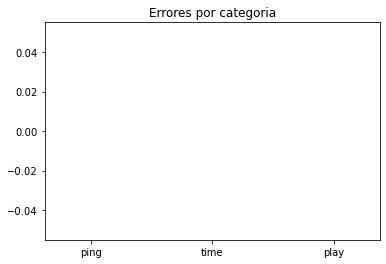

In [15]:
width = 1
xticks = np.linspace(0, 4, len(command_index))
for i, errors in enumerate(label_errors.values()):
    class_error_count = sum(errors.values())
    plt.bar(xticks[i], class_error_count, width)

plt.title("Errores por categoria")
plt.xticks(xticks, command_index.keys())
plt.show()

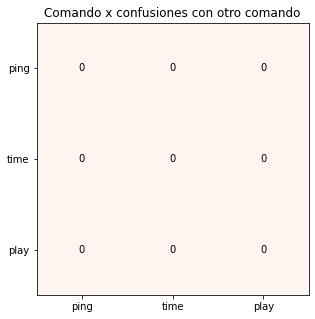

In [16]:
plt.figure(figsize=(5, 5))

error_matrix = np.transpose(np.array([[*errors.values()] for errors in label_errors.values()]))
plot_size = len(label_errors)

for i in range(plot_size):
    for j in range(plot_size):
        plt.text(j, i, error_matrix[i, j], ha="center", va="center")

ticks = np.arange(plot_size)
plt.xticks(ticks, command_index.keys())
plt.yticks(ticks, command_index.keys())
plt.title("Comando x confusiones con otro comando")
plt.imshow(error_matrix, cmap=plt.get_cmap("Reds"))
plt.show()

### Ejemplos de errores:

In [17]:
ERROR_AMOUNT = len(error_indices)
DISPLAY_AMOUNT = min(20, ERROR_AMOUNT)

if DISPLAY_AMOUNT > 0:
    np.random.seed(23)
    error_samples = np.random.randint(0, ERROR_AMOUNT, size=DISPLAY_AMOUNT)
    
    fig, axs = plt.subplots(DISPLAY_AMOUNT//3 + 2, 3, figsize=(15, 4 * (DISPLAY_AMOUNT // 3 + 2)))
    for i in range(DISPLAY_AMOUNT):
        ROW = i // 3
        COL = i % 3
        
        TEXT_INDEX = error_indices[error_samples[i]]
        command_prediction = predictions[TEXT_INDEX]
        classification = predicted_classification(TEXT_INDEX)

        frase = test_data[TEXT_INDEX]
        axs[ROW, COL].text(1, 0.5, f"\"{frase}\"", fontsize=12, fontstyle="italic")

        width = 1
        xticks = np.linspace(0, 5, len(command_index), command_index.keys())
        for c in range(len(command_index)):
            axs[ROW, COL].bar(xticks[c], command_prediction[c], width, color='r')

        axs[ROW, COL].set_xticks(xticks)
        axs[ROW, COL].set_xticklabels(command_index.keys())
        axs[ROW, COL].set_yticks(np.arange(0, 1.1, step=0.1))

        certainty = round(np.max(command_prediction) * 100, 2)
        axs[ROW, COL].text(3, 0.9, f"{certainty}% {classification}", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()
else:
    print("No hubo errores")

No hubo errores


In [30]:
encoded_data = encode_data(np.array(["hay lag?"]))
print(encoded_data)
prediction = model.predict(encoded_data)
print(prediction)
best_index = np.argmax(prediction)
print(best_index)
inverse_command_index[best_index]

tf.Tensor([[8 9 0 0 0 0 0 0 0 0]], shape=(1, 10), dtype=int32)
[[0.9656184  0.01401153 0.02037008]]
0


'ping'

In [19]:
tokenizer.texts_to_sequences(np.array(["hay lag"]))

[[8, 9]]